In [1]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [2]:


def compute_var(variance, n):
    return np.sum(variance[n:])


def compute_p(k, null_k):
    return (np.sum(null_k < k) / len(null_k))


from Experiment_1.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from Experiment_1.net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE

matplotlib.rcParams['axes.linewidth'] = .5


In [3]:
def compute_var(variance,n):
    return np.sum(variance[n:])

def compute_p(k, null_k):
    return (np.sum(null_k<k)/len(null_k))

ModuleNotFoundError: No module named 'numpy._core'

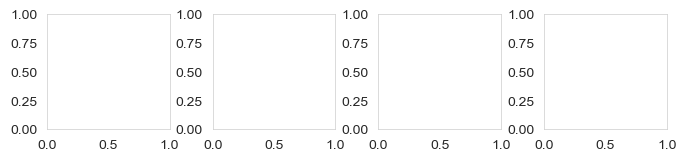

In [8]:
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(8,1.5))
gs = gridspec.GridSpec(1,4,wspace = .35)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df_act = pd.concat(df_list,ignore_index=True) 
original_df_act = original_df_act[original_df_act.mse_z<.035]
original_df_act = original_df_act[original_df_act.lambda_std==0.1]
original_df_act = original_df_act[original_df_act.n==100]
ibloriginal_df = pd.read_pickle("IBLdf.pkl")  
#ibloriginal_df = ibloriginal_df[ibloriginal_df.n_active == 50]
#original_df_act = original_df_act[original_df_act.sigma_rec==0.]
#original_df_act = original_df_act[original_df_act.n==100]
#original_df_act = original_df_act[original_df_act.beta==20.]
#original_df_act = original_df_act[original_df_act.activity_std<.01]
#original_df_act = original_df_act[original_df_act.beta==5.]


#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(3):
    ax = axes[i]
    k = i+2
    df = original_df_act.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
    df['var'] = np.log(df['var'])
    df = df[df.dim==k]
    
    ibl_df = ibloriginal_df.copy()
    ibl_df['var'] = ibl_df.variance.apply(lambda x: x[k-1])
    ibl_df['k_inertia'] = ibl_df.inertia.apply(lambda x: x[k-1])
    ibl_df['var'] = np.log(ibl_df['var'])


    
      # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
    null_df = null_df.groupby(['model_id']).mean().reset_index()
    
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=.75,bins=(50,50),color='gray')
    sns.histplot(data=ibl_df, x='var',y='k_inertia',ax=ax,legend=False,alpha=.75,bins=(25,25))


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    for sigma_rec in [0., 0.2]:
        for sample in range(100):   
            #try:
            frac = .8
            sample_df = df.sample(frac=frac)
            x = sample_df['var'].values.astype(float)
            y = sample_df.k_inertia.values
    
            sample_null_df = null_df.sample(frac=frac)
            x_null = sample_null_df['var'].values.astype(float)
            y_null = sample_null_df.inertia.values
            
            sample_ibl_df = ibl_df.sample(frac=frac)
            x_ibl = sample_ibl_df['var'].values.astype(float)
            y_ibl = sample_ibl_df.k_inertia.values
    
            try:
                popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
                #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
                y_fit = f(x_values, *popt)
    
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step': step,
                                     'k':k,
                                     'sigma_rec':sigma_rec,
                                 'type': 1,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
                continue
        

            try:
                popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
                y_fit = f(x_values, *popt)
                for step in range(20):
                    fit_rows.append({'sample':sample,
                                     'step':step,
                                     'k':k,
                                     'sigma_rec':sigma_rec,
                                 'type': 0,
                                 'x':x_values[step],
                                 'y': y_fit[step],
                                 'a':popt[0]})
            except:
               continue
                
            #try:
            popt, pcov = opt.curve_fit(f, x_ibl, y_ibl, method="trf",max_nfev=10000,bounds = bounds)
            y_fit = f(x_values, *popt)
            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step':step,
                                 'k':k,
                                 'sigma_rec':sigma_rec,
                             'type': 2,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
            # except:
            #    continue
  
# 
# # 
# fit_df = pd.DataFrame(fit_rows)
# for k in range(4):
#     ax = axes[k]
#     sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',alpha = 1,errorbar=None, linestyle='--')
#     sns.lineplot(data = fit_df[(fit_df.type==2)& (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='tab:blue',linestyle='--',alpha= 1, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=7,bottom=True)
    ax.yaxis.set_tick_params(labelsize=7,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
   #  ax.set_ylim(-.05,1)
   #  ax.set_xlim(-5,0)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=8)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=8)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=8)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=8)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

In [53]:
ibloriginal_df.n_time.unique()

array([25])

In [22]:
ibl_df

,beryl,cosmos,eid,n_time,n_active,sigma,trial_length,n_splits,variance,inertia,...,null_inertia,activity_std,n_neurons,responses,mean_responses,n_trials,p,z,var,k_inertia
0,AAA,CNU,7b26ce84-07f9-43d1-957f-bc72aeb730a3,10,50,2.0,0.50,25,"[0.7340936777523241, 0.6085556292188727, 0.541...","[0.8827532429675637, 0.664061151134736, 0.5604...",...,"[[0.9990915347386197, 0.9996048525155004, 0.99...",7.509060e-16,1250,"[[1.953600537915028, 1.7817473825097987, 1.485...","[[-1.12974788597886, -1.1033301035320764, -1.0...",975,False,-51.531752,1.680352,0.519668
1,ACAd,Isocortex,259927fd-7563-4b03-bc5d-17b4d0fa7a55,10,50,2.0,0.50,25,"[0.8474908665101067, 0.7482332851648377, 0.667...","[0.9554771974191157, 0.7219367619542203, 0.597...",...,"[[0.9988321319286709, 0.9989979247858606, 0.99...",5.169330e-16,1250,"[[-1.8383211501467598, -1.7072118989873248, -1...","[[-1.0904748535303397, -1.0874415461926823, -1...",646,False,-51.249073,1.988552,0.531220
2,ACAd,Isocortex,28741f91-c837-4147-939e-918d38d849f2,10,50,2.0,0.50,25,"[0.8601600118611632, 0.7837466275096385, 0.731...","[0.9422736096757702, 0.7698231273866468, 0.678...",...,"[[0.9996306652635767, 0.9990486235855318, 0.99...",6.003590e-16,1250,"[[-0.01738103979758364, -0.002434574551891145,...","[[1.0309053999390139, 1.2051208358278636, 1.52...",401,False,-51.736356,2.211219,0.619550
3,ACAd,Isocortex,a4000c2f-fa75-4b3e-8f06-a7cf599b87ad,10,50,2.0,0.50,25,"[0.8830303327003819, 0.8035140817360182, 0.747...","[0.9338120694372506, 0.7634487382820749, 0.649...",...,"[[0.9992612512848159, 0.9988461379407533, 0.99...",4.217370e-16,1250,"[[-0.9724378288560317, -0.7647943751260255, -0...","[[-1.0456900926539454, -0.8321298757607403, -0...",653,False,-48.548869,2.212213,0.585443
4,ACAd,Isocortex,aad23144-0e52-4eac-80c5-c4ee2decb198,10,50,2.0,0.50,25,"[0.730720102294724, 0.6472507966863836, 0.5876...","[0.801661853531863, 0.651541512367142, 0.57542...",...,"[[0.9989578584448885, 0.9984666348460992, 0.99...",2.802710e-16,1250,"[[0.8537854494754799, 0.6050154901284328, 0.14...","[[-0.3151054014756504, -0.16332321347107168, 0...",641,False,-54.697188,1.846440,0.471462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,ZI,HY,a82800ce-f4e3-4464-9b80-4c3d6fade333,10,50,2.0,0.50,25,"[0.6710078559363959, 0.5134526958337317, 0.469...","[0.8417465661943905, 0.5813510758161914, 0.369...",...,"[[0.999683751611799, 0.9989983161353502, 0.999...",5.382770e-16,1250,"[[2.6967182747691196, 2.254769319558357, 1.663...","[[1.7156104197723228, 1.2050018031079694, 0.49...",672,False,-39.851802,1.528797,0.322199
1358,ZI,HY,c557324b-b95d-414c-888f-6ee1329a2329,10,50,2.0,0.50,25,"[0.7087956401097212, 0.5789447471366111, 0.496...","[0.7990479783697294, 0.646801984477558, 0.5656...",...,"[[0.9994168023743711, 0.9997002442544082, 0.99...",9.592930e-16,1250,"[[0.4725348455630591, 0.31917387291340643, 0.0...","[[1.4994817804071043, 1.2530972701090892, 0.79...",1053,False,-47.992519,1.533653,0.511476
1359,ZI,HY,cb2ad999-a6cb-42ff-bf71-1774c57e5308,10,50,2.0,0.50,25,"[0.5993960365085564, 0.3951559676998281, 0.359...","[0.811802397757145, 0.5479273698193085, 0.3510...",...,"[[0.9990402602521444, 0.9992550871021363, 0.99...",4.424320e-16,1250,"[[-0.04035683335450408, -0.20997240290537372, ...","[[1.3326863764358332, 0.8388166582764489, 0.07...",872,False,-37.451111,1.116770,0.322040
1360,ZI,HY,e8b4fda3-7fe4-4706-8ec2-91036cfee6bd,10,50,2.0,0.50,25,"[0.6699234998322009, 0.5824380317052031, 0.526...","[0.7906172349321983, 0.5781656627507422, 0.507...",...,"[[0.9994075614037555, 0.999456715853113, 0.999...",5.932660e-16,1250,"[[-0.8089578625999083, -0.6929669870259011, -0...","[[-0.7637723056144511, -0.6886351147608691, -0...",527,False,-38.608072,1.681525,0.440061


In [16]:
ibl_df

,beryl,cosmos,eid,n_time,n_active,sigma,trial_length,n_splits,variance,inertia,...,null_inertia,activity_std,n_neurons,responses,mean_responses,n_trials,p,z,var,k_inertia
0,AAA,CNU,7b26ce84-07f9-43d1-957f-bc72aeb730a3,10,50,2.0,0.50,25,"[0.7340936777523241, 0.6085556292188727, 0.541...","[0.8827532429675637, 0.664061151134736, 0.5604...",...,"[[0.9990915347386197, 0.9996048525155004, 0.99...",7.509060e-16,1250,"[[1.953600537915028, 1.7817473825097987, 1.485...","[[-1.12974788597886, -1.1033301035320764, -1.0...",975,False,-51.531752,NaN,NaN
1,ACAd,Isocortex,259927fd-7563-4b03-bc5d-17b4d0fa7a55,10,50,2.0,0.50,25,"[0.8474908665101067, 0.7482332851648377, 0.667...","[0.9554771974191157, 0.7219367619542203, 0.597...",...,"[[0.9988321319286709, 0.9989979247858606, 0.99...",5.169330e-16,1250,"[[-1.8383211501467598, -1.7072118989873248, -1...","[[-1.0904748535303397, -1.0874415461926823, -1...",646,False,-51.249073,NaN,NaN
2,ACAd,Isocortex,28741f91-c837-4147-939e-918d38d849f2,10,50,2.0,0.50,25,"[0.8601600118611632, 0.7837466275096385, 0.731...","[0.9422736096757702, 0.7698231273866468, 0.678...",...,"[[0.9996306652635767, 0.9990486235855318, 0.99...",6.003590e-16,1250,"[[-0.01738103979758364, -0.002434574551891145,...","[[1.0309053999390139, 1.2051208358278636, 1.52...",401,False,-51.736356,NaN,NaN
3,ACAd,Isocortex,a4000c2f-fa75-4b3e-8f06-a7cf599b87ad,10,50,2.0,0.50,25,"[0.8830303327003819, 0.8035140817360182, 0.747...","[0.9338120694372506, 0.7634487382820749, 0.649...",...,"[[0.9992612512848159, 0.9988461379407533, 0.99...",4.217370e-16,1250,"[[-0.9724378288560317, -0.7647943751260255, -0...","[[-1.0456900926539454, -0.8321298757607403, -0...",653,False,-48.548869,NaN,NaN
4,ACAd,Isocortex,aad23144-0e52-4eac-80c5-c4ee2decb198,10,50,2.0,0.50,25,"[0.730720102294724, 0.6472507966863836, 0.5876...","[0.801661853531863, 0.651541512367142, 0.57542...",...,"[[0.9989578584448885, 0.9984666348460992, 0.99...",2.802710e-16,1250,"[[0.8537854494754799, 0.6050154901284328, 0.14...","[[-0.3151054014756504, -0.16332321347107168, 0...",641,False,-54.697188,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,ZI,HY,a82800ce-f4e3-4464-9b80-4c3d6fade333,10,50,2.0,0.50,25,"[0.6710078559363959, 0.5134526958337317, 0.469...","[0.8417465661943905, 0.5813510758161914, 0.369...",...,"[[0.999683751611799, 0.9989983161353502, 0.999...",5.382770e-16,1250,"[[2.6967182747691196, 2.254769319558357, 1.663...","[[1.7156104197723228, 1.2050018031079694, 0.49...",672,False,-39.851802,NaN,NaN
1358,ZI,HY,c557324b-b95d-414c-888f-6ee1329a2329,10,50,2.0,0.50,25,"[0.7087956401097212, 0.5789447471366111, 0.496...","[0.7990479783697294, 0.646801984477558, 0.5656...",...,"[[0.9994168023743711, 0.9997002442544082, 0.99...",9.592930e-16,1250,"[[0.4725348455630591, 0.31917387291340643, 0.0...","[[1.4994817804071043, 1.2530972701090892, 0.79...",1053,False,-47.992519,NaN,NaN
1359,ZI,HY,cb2ad999-a6cb-42ff-bf71-1774c57e5308,10,50,2.0,0.50,25,"[0.5993960365085564, 0.3951559676998281, 0.359...","[0.811802397757145, 0.5479273698193085, 0.3510...",...,"[[0.9990402602521444, 0.9992550871021363, 0.99...",4.424320e-16,1250,"[[-0.04035683335450408, -0.20997240290537372, ...","[[1.3326863764358332, 0.8388166582764489, 0.07...",872,False,-37.451111,NaN,NaN
1360,ZI,HY,e8b4fda3-7fe4-4706-8ec2-91036cfee6bd,10,50,2.0,0.50,25,"[0.6699234998322009, 0.5824380317052031, 0.526...","[0.7906172349321983, 0.5781656627507422, 0.507...",...,"[[0.9994075614037555, 0.999456715853113, 0.999...",5.932660e-16,1250,"[[-0.8089578625999083, -0.6929669870259011, -0...","[[-0.7637723056144511, -0.6886351147608691, -0...",527,False,-38.608072,NaN,NaN
